In [1]:

%load_ext autoreload
%autoreload 2
import os
import dask
import panel
import pandas as pd
import matplotlib.pyplot as plt
import nisardev as nisar
import grimpfunc as grimp
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import geopandas as gpd
import glob
import shapely
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set(num_workers=2)  # Avoid problems with too many open connections at NSIDC
panel.extension() 

In [2]:
#paths

centreline_path = "/Users/sofiasuhinin/Desktop/GrIS_Calving/flowlines/glacier0001_iter03.shp"
terminus_path = "/Users/sofiasuhinin/Desktop/GrIS_Calving/Jakobshavn-Isbrae-CalvingStatistics/data/MEaSUREs_0781/collated/JakbobshavnIsbraeTerminus.shp"
velocity_path = "/Users/sofiasuhinin/Desktop/GrIS_Calving/Jakobshavn-Isbrae-CalvingStatistics/data/MEaSUREs_0766/JakobshavnIsbraeVelocitySeriesNew.nc"

#read in velocity 
velocity = xr.open_dataset(velocity_path)

#read in centreline + make sure coordinate system = EPSG:3413
centreline = gpd.read_file(centreline_path)
centreline = centreline.to_crs("EPSG:3413")

centreline_shape = centreline.geometry.iloc[0]

#read in terminus
terminus = gpd.read_file(terminus_path)
terminus = terminus.to_crs("EPSG:3413")

terminus = terminus.rename(columns={"SourceDate": "Date"}) #rename for simplicity
terminus["Date"] = pd.to_datetime(terminus["Date"]) #make sure it is in datetime 

In [3]:
print(centreline.crs)
print(terminus.crs)

EPSG:3413
EPSG:3413


In [4]:
velocity

<xarray.Dataset> Size: 259MB
Dimensions:      (x: 206, y: 226, time: 463, band: 3)
Coordinates:
  * x            (x) float64 2kB -2.056e+05 -2.054e+05 ... -1.648e+05 -1.646e+05
  * y            (y) float64 2kB -2.249e+06 -2.249e+06 ... -2.294e+06 -2.294e+06
  * time         (time) datetime64[ns] 4kB 2015-01-06T12:00:00 ... 2024-12-14...
  * band         (band) <U2 24B 'vx' 'vy' 'vv'
    name         <U4 16B ...
    _FillValue   (band) float64 24B ...
    time1        (time) datetime64[ns] 4kB ...
    time2        (time) datetime64[ns] 4kB ...
Data variables:
    spatial_ref  int64 8B ...
    VelocityMap  (time, band, y, x) float32 259MB ...

In [10]:
#intersection 

def intersection(centreline, terminus_line):
    intersect = centreline.intersection(terminus_line)

    if intersect.is_empty:
        return None
    
    if intersect.geom_type == "MultiPoint": #if there is more than one intersect put the point closes to the centre of the terminus line
        return min(intersect.geoms, key = lambda p: p.distance(terminus_line.centroid))
    
    return intersect

In [14]:
pts = []

for i in range(len(terminus)):
    terminus_line = terminus.geometry.iloc[i]
    pt = intersection(centreline_shape, terminus_line)
    pts.append(pt)

terminus["intersect_points"] = pts

terminus.head()

,Image_ID,Image_Tile,Date,Quality_Fl,Glacier_ID,geometry,intersect_points
0,SEN1_NSIDC_0723_V2_20160201_20160212,S1A_090_009787,2016-02-03,0,3,"LINESTRING (-184523.658 -2277242.523, -184005....",POINT (-182041.25466858875 -2275501.966626903)
1,SEN1_NSIDC_0723_V2_20170201_20170206,S1B_090_004141,2017-02-03,1,3,"LINESTRING (-185836.057 -2276614.059, -185698....",None
2,SEN1_NSIDC_0723_V2_20190215_20190220,S1B_090_014991,2019-02-17,1,3,"LINESTRING (-185915.432 -2276582.309, -185957....",None
3,SEN1_NSIDC_0723_V2_20150101_20150112,S1A_090_004012,2015-01-03,0,3,"LINESTRING (-188606.112 -2265922.891, -188399....",POINT (-182302.33390831872 -2275255.0299488134)
4,SEN1_NSIDC_0723_V2_20150113_20150124,S1A_090_004187,2015-01-15,1,3,"LINESTRING (-188634.464 -2265910.404, -188629....",POINT (-182654.5811722098 -2274965.15839306)


In [9]:
terminus

,Image_ID,Image_Tile,Date,Quality_Fl,Glacier_ID,geometry
0,SEN1_NSIDC_0723_V2_20160201_20160212,S1A_090_009787,2016-02-03,0,3,"LINESTRING (-184523.658 -2277242.523, -184005...."
1,SEN1_NSIDC_0723_V2_20170201_20170206,S1B_090_004141,2017-02-03,1,3,"LINESTRING (-185836.057 -2276614.059, -185698...."
2,SEN1_NSIDC_0723_V2_20190215_20190220,S1B_090_014991,2019-02-17,1,3,"LINESTRING (-185915.432 -2276582.309, -185957...."
3,SEN1_NSIDC_0723_V2_20150101_20150112,S1A_090_004012,2015-01-03,0,3,"LINESTRING (-188606.112 -2265922.891, -188399...."
4,SEN1_NSIDC_0723_V2_20150113_20150124,S1A_090_004187,2015-01-15,1,3,"LINESTRING (-188634.464 -2265910.404, -188629...."
...,...,...,...,...,...,...
352,SEN1_NSIDC_0723_V4_20211201_20211206,S1B_090_029866,2021-12-03,1,3,"LINESTRING (-185164.014 -2276666.976, -184867...."
353,SEN1_NSIDC_0723_V4_20211207_20211212,S1A_090_040937,2021-12-09,1,3,"LINESTRING (-184931.18 -2276910.393, -184380.8..."
354,SEN1_NSIDC_0723_V4_20211213_20211218,S1B_090_030041,2021-12-15,1,3,"LINESTRING (-184793.596 -2276973.893, -184497...."
355,SEN1_NSIDC_0723_V4_20211219_20211224,S1A_090_041112,2021-12-21,1,3,"LINESTRING (-184719.513 -2277016.227, -184391...."


In [76]:
none_vals = terminus["intersect_points"].isna().sum()
print(none_vals)

111


In [79]:
total = len(terminus["intersect_points"])
print(total)

357


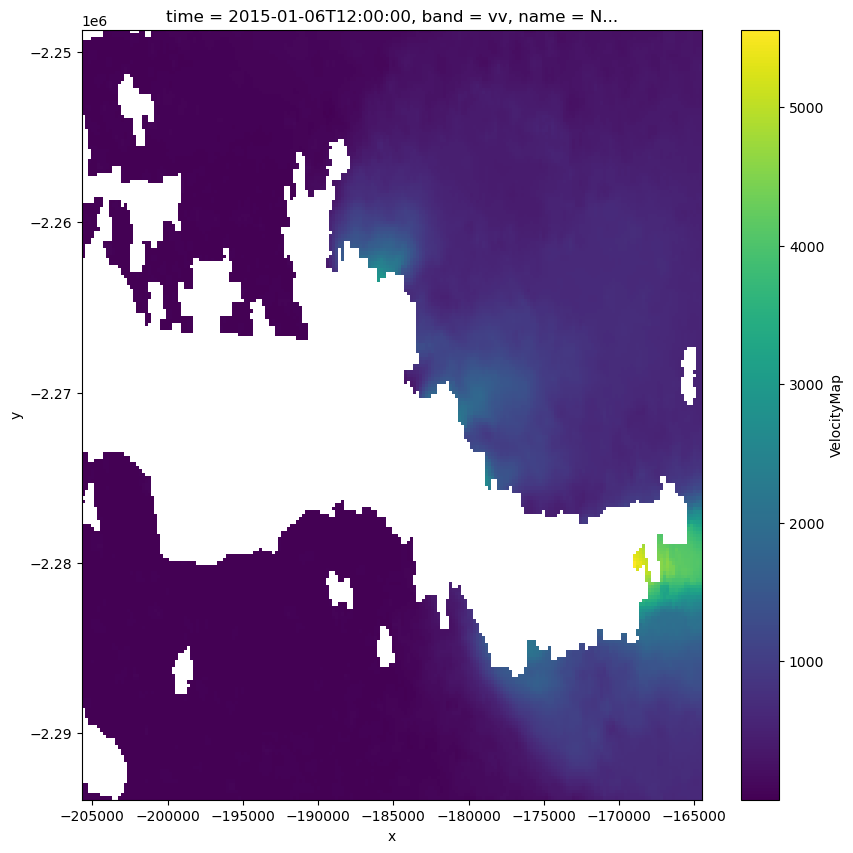

In [54]:

sampletime = 0  # first time slice
vel_slice = velocity["VelocityMap"].isel(band=2, time=sampletime)

vel_slice = vel_slice.assign_coords(
    x=("x", x_vals),
    y=("y", y_vals),
)

fig, ax = plt.subplots(figsize=(10, 10))

vel_slice.plot(
    ax=ax,
    x="x",         
    y="y",         
    add_colorbar=True,
)

plt.show()

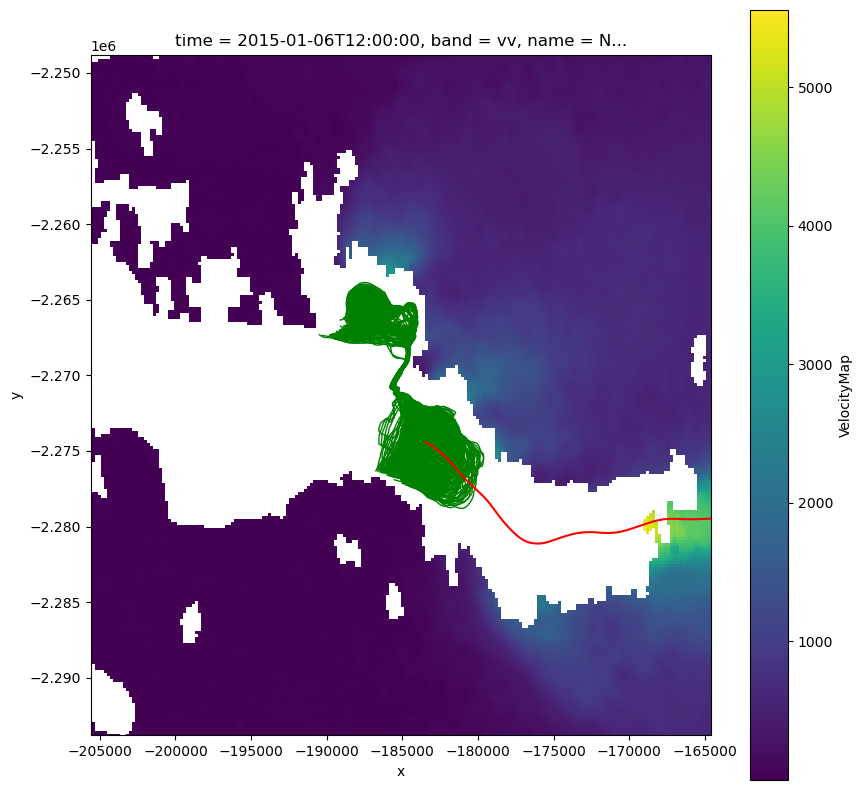

In [56]:

sampletime = 0  # first time slice
vel_slice = velocity["VelocityMap"].isel(band=2, time=sampletime)

vel_slice = vel_slice.assign_coords(
    x=("x", x_vals),
    y=("y", y_vals),
)

fig, ax = plt.subplots(figsize=(10, 10))


vel_slice.plot(
    ax=ax,
    x="x",         
    y="y",         
    add_colorbar=True,
)


terminus.plot(
    ax=ax,
    facecolor="none",
    edgecolor="green",
    linewidth=1,
)

centreline_gs = gpd.GeoSeries([centreline_shape], crs=terminus.crs if hasattr(terminus, "crs") else None)
centreline_gs.plot(
    ax=ax,
    color="red",
    linewidth=1.5,
)

ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(y_vals.min(), y_vals.max())
ax.set_aspect("equal")

plt.show()


In [59]:
vel_band

<xarray.DataArray 'VelocityMap' (time: 463, y: 226, x: 206)> Size: 86MB
array([[[       nan,        nan, ..., 288.54684 , 284.4607  ],
        [       nan,        nan, ..., 290.5326  , 286.57245 ],
        ...,
        [ 21.886179,  15.599247, ..., 640.2511  , 648.72314 ],
        [ 19.863163,  14.036021, ..., 644.3369  , 651.7844  ]],

       [[       nan,        nan, ..., 248.77605 , 250.87611 ],
        [       nan,        nan, ..., 260.5624  , 261.13486 ],
        ...,
        [ 25.127302,        nan, ..., 709.6123  , 724.73834 ],
        [ 28.339035,  26.72713 , ..., 722.0713  , 728.7099  ]],

       ...,

       [[       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan],
        ...,
        [  7.977735,  10.795876, ..., 555.65076 , 557.69214 ],
        [  7.390808,   3.545655, ..., 558.34955 , 560.0926  ]],

       [[ 17.808392,  33.021847, ...,        nan,        nan],
        [ 15.765285,  15.566046, ...,        nan,        nan],
        ...,
        [ 17.101013,   2.338846, ..., 574.9012  , 574.3499  ],
        [ 14.436469,   3.474755, ..., 572.6764  , 579.8726  ]]], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 4kB 2015-01-06T12:00:00 ... 2024-12-14T...
    band        <U2 8B 'vv'
    name        <U4 16B ...
    _FillValue  float64 8B ...
    time1       (time) datetime64[ns] 4kB ...
    time2       (time) datetime64[ns] 4kB ...
  * x           (x) float64 2kB -2.056e+05 -2.054e+05 ... -1.648e+05 -1.646e+05
  * y           (y) float64 2kB -2.249e+06 -2.249e+06 ... -2.294e+06 -2.294e+06
Attributes:
    grid_mapping:  spatial_ref

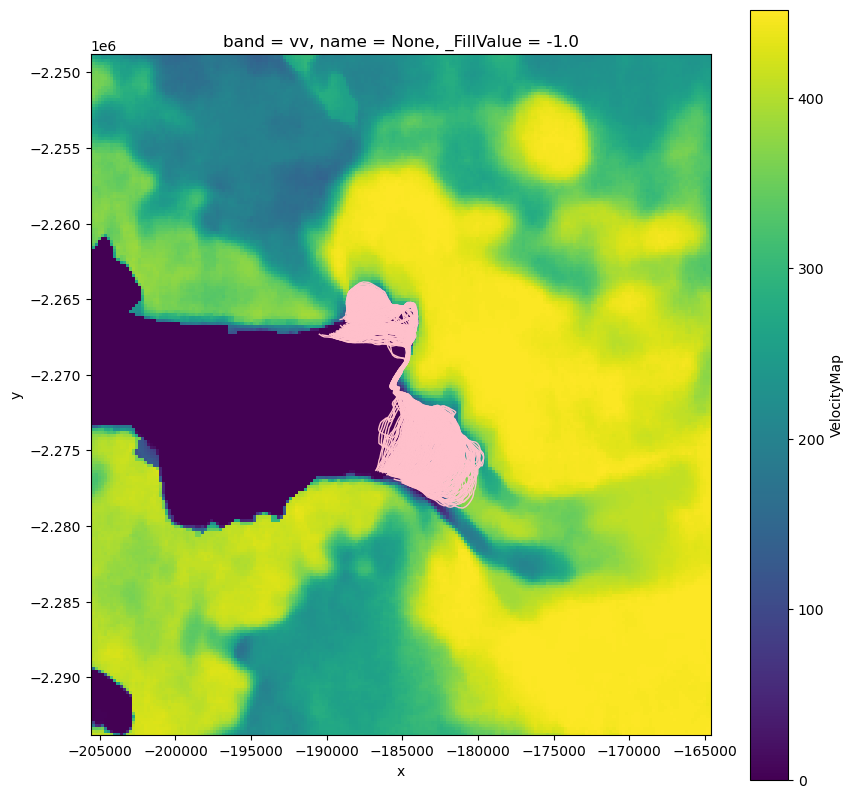

In [70]:

vel_band = velocity["VelocityMap"].isel(band=2)

valid_count = vel_band.count(dim="time") 

fig, ax = plt.subplots(figsize=(10, 10))

valid_count.plot(
    ax=ax,
    x="x",
    y="y",
    add_colorbar=True,
)

# # 4. Overlay terminus geometries (GeoDataFrame)
terminus.plot(
     ax=ax,
     facecolor="none",
     edgecolor="pink",
     linewidth=1,
)

ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(y_vals.min(), y_vals.max())
ax.set_aspect("equal")
plt.show()


In [73]:
#buffer

buffer_m = 1000  
terminus_buffer = terminus.buffer(buffer_m)

terminus_buffer_gdf = gpd.GeoDataFrame(
    geometry=terminus_buffer,
    crs=terminus.crs
)

vel_band = velocity["VelocityMap"].isel(band=2)  # 'vv' magnitude band

vel_band = vel_band.rio.write_crs(terminus.crs, inplace=True)

slice_t = vel_band.isel(time=0)
clipped = slice_t.rio.clip(terminus_buffer_gdf.geometry)
np.isfinite(clipped.values).any()



np.True_

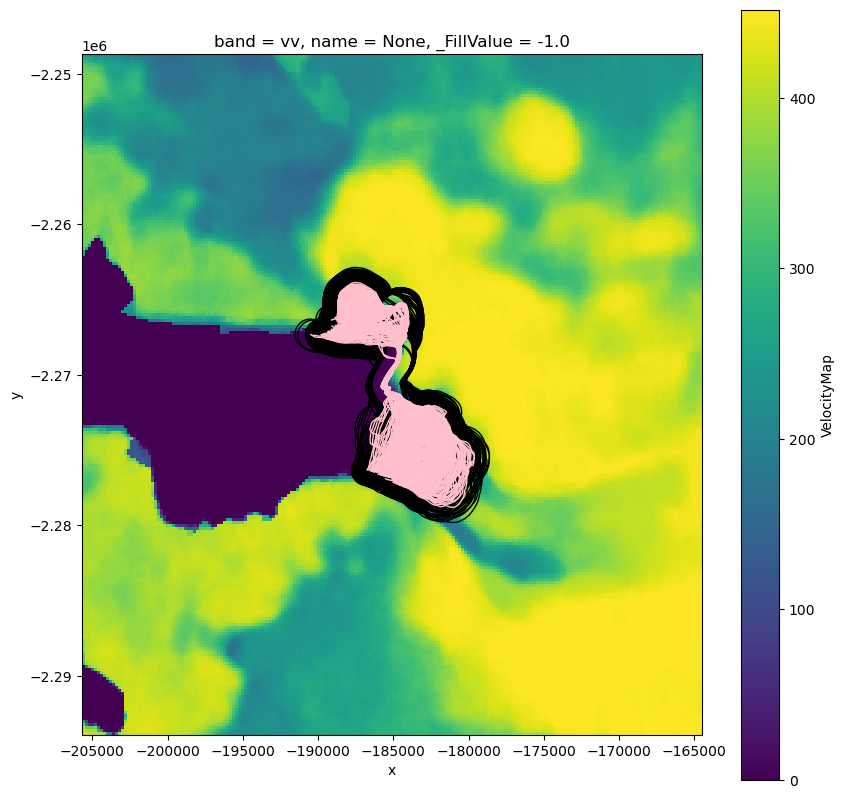

In [75]:
fig, ax = plt.subplots(figsize=(10, 10))

valid_count.plot(ax=ax, x="x", y="y")

terminus.plot(ax=ax, color="pink", linewidth=1)
terminus_buffer_gdf.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)

ax.set_aspect("equal")
plt.show()

In [ ]:
#ignore after here

In [2]:
velocity = xr.open_dataset('/Users/sofiasuhinin/Desktop/GrIS_Calving/Jakobshavn-Isbrae-CalvingStatistics/data/MEaSUREs_0766/JakobshavnIsbraeVelocitySeries2.nc')
centreline = gpd.read_file('/Users/sofiasuhinin/Desktop/GrIS_Calving/flowlines/glacier0001_iter03.shp')
terminus = pd.read_csv('/Users/sofiasuhinin/Desktop/GrIS_Calving/Jakobshavn-Isbrae-CalvingStatistics/centreline1.csv', skiprows = 1)

In [3]:
terminus

,Year,Month,Day,Serial Date (num days from 0th Jan 0000),Terminus Position on flowline,Terminus position relative to most recent observation (m),Terminus change (m),Rate of Terminus Change (m/yr),Terminus Width (m),Terminus path length (m),Mean distance between nodes (m)
0,2015,1,3,735970.0,1492.80,445.630,NaN,0.0,12146,22522,369.22
1,2015,1,15,735980.0,1036.50,-10.635,-456.270,-13878.0,11859,20521,336.42
2,2015,1,27,735990.0,1112.70,65.546,76.181,2317.2,11570,22995,242.05
3,2015,2,8,736000.0,790.49,-256.690,-322.240,-9801.4,12657,25215,345.42
4,2015,2,20,736020.0,1937.40,890.210,1146.900,34885.0,11831,21361,220.21
...,...,...,...,...,...,...,...,...,...,...,...
241,2021,11,27,738490.0,1394.10,346.900,-264.480,-16089.0,10801,29389,212.97
242,2021,12,3,738490.0,1204.90,157.720,-189.170,-11508.0,11095,31781,254.25
243,2021,12,9,738500.0,1446.70,399.550,241.830,14711.0,11327,32199,263.92
244,2021,12,15,738500.0,1280.10,232.880,-166.670,-10139.0,11422,30307,240.53


In [4]:
velocity

<xarray.Dataset> Size: 81MB
Dimensions:      (x: 121, y: 121, time: 463, band: 3)
Coordinates:
  * x            (x) float64 968B -1.94e+05 -1.938e+05 ... -1.702e+05 -1.7e+05
  * y            (y) float64 968B -2.264e+06 -2.264e+06 ... -2.288e+06
  * time         (time) datetime64[ns] 4kB 2015-01-06T12:00:00 ... 2024-12-14...
  * band         (band) <U2 24B 'vx' 'vy' 'vv'
    name         <U4 16B ...
    _FillValue   (band) float64 24B ...
    time1        (time) datetime64[ns] 4kB ...
    time2        (time) datetime64[ns] 4kB ...
Data variables:
    spatial_ref  int64 8B ...
    VelocityMap  (time, band, y, x) float32 81MB ...

In [5]:
#change to date time (this is a thing)
terminus["Date"] = pd.to_datetime(
    dict(year = terminus["Year"],
        month = terminus["Month"],
        day = terminus["Day"])
)

terminus = terminus.rename(columns = {
    "Terminus Position on flowline": "L",
    "Terminus change (m)": "del_L"
})

#for simplicity i just want these (for now, tbd)
terminus_columns = ["Date", "L", "del_L"]
terminus = terminus[terminus_columns].sort_values("Date").reset_index(drop= True)


In [6]:
terminus

,Date,L,del_L
0,2015-01-03,1492.80,NaN
1,2015-01-15,1036.50,-456.270
2,2015-01-27,1112.70,76.181
3,2015-02-08,790.49,-322.240
4,2015-02-20,1937.40,1146.900
...,...,...,...
241,2021-11-27,1394.10,-264.480
242,2021-12-03,1204.90,-189.170
243,2021-12-09,1446.70,241.830
244,2021-12-15,1280.10,-166.670


In [7]:
#terminus df 
df = terminus.copy().sort_values("Date").reset_index(drop=True)

#dt calc
df["dt_days"] = df["Date"].diff().dt.days
df["dt_years"] = df["dt_days"] / 365.25

#dL calc
df["dL"] = df["L"].diff()
df["dLdt_per_year"] = df["dL"] / df["dt_years"]

df[["Date", "L", "dt_days", "dL", "dLdt_per_year"]].head(10)

#dLdt = dL ( 6 days) - terminus change between data / dt (per year)




,Date,L,dt_days,dL,dLdt_per_year
0,2015-01-03,1492.80,NaN,NaN,NaN
1,2015-01-15,1036.50,12.0,-456.30,-13888.631250
2,2015-01-27,1112.70,12.0,76.20,2319.337500
3,2015-02-08,790.49,12.0,-322.21,-9807.266875
4,2015-02-20,1937.40,12.0,1146.91,34909.073125
5,2015-03-04,1518.00,12.0,-419.40,-12765.487500
6,2015-03-16,1139.70,12.0,-378.30,-11514.506250
7,2015-03-28,645.19,12.0,-494.51,-15051.648125
8,2015-04-09,884.89,12.0,239.70,7295.868750
9,2015-04-21,489.40,12.0,-395.49,-12037.726875


In [8]:
#so w my velocity i should pick a point on the terminus right 
# - probably where it intersects the centreline

centreline.length

0    564300.353452
dtype: float64

In [9]:
velocity

<xarray.Dataset> Size: 81MB
Dimensions:      (x: 121, y: 121, time: 463, band: 3)
Coordinates:
  * x            (x) float64 968B -1.94e+05 -1.938e+05 ... -1.702e+05 -1.7e+05
  * y            (y) float64 968B -2.264e+06 -2.264e+06 ... -2.288e+06
  * time         (time) datetime64[ns] 4kB 2015-01-06T12:00:00 ... 2024-12-14...
  * band         (band) <U2 24B 'vx' 'vy' 'vv'
    name         <U4 16B ...
    _FillValue   (band) float64 24B ...
    time1        (time) datetime64[ns] 4kB ...
    time2        (time) datetime64[ns] 4kB ...
Data variables:
    spatial_ref  int64 8B ...
    VelocityMap  (time, band, y, x) float32 81MB ...

In [10]:
vv = velocity["VelocityMap"].sel(band="vv")
print("min, max:", float(vv.min()), float(vv.max()))

min, max: 0.006762796081602573 16439.25


In [11]:
xmin, xmax = float(vv.x.min()), float(vv.x.max())
ymin, ymax = float(vv.y.min()), float(vv.y.max())
print(xmin, xmax, ymin, ymax)

-194000.0 -170000.0 -2288000.0 -2264000.0


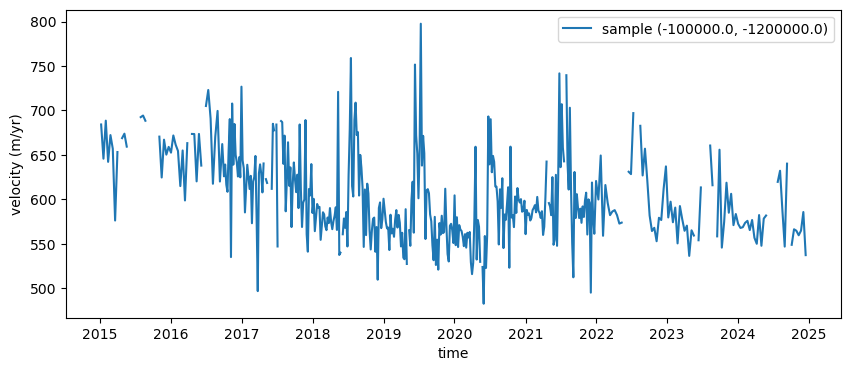

In [12]:
x0 = -100000.0
y0 = -1200000.0

label = 'sample'

vv_band = velocity["VelocityMap"].sel(band='vv')

vel_sample_pt = vv_band.sel(x=x0, y=y0, method='nearest')
df_selected_point = vel_sample_pt.to_dataframe().reset_index()

plt.figure(figsize=(10,4))
plt.plot(df_selected_point['time'], df_selected_point['VelocityMap'], label=f'{label} ({x0}, {y0})')
plt.xlabel('time')
plt.ylabel('velocity (m/yr)')
plt.legend()
plt.show()

#should clean this? claire has a notebook on this 
#should also find a way to pick a point near the terminsu 
# no needto interpooalte

In [13]:
vv = velocity["VelocityMap"].sel(band="vv")
vel_times = vv.time.values

vel_series = vv.sel(x=x0, y=y0, method="nearest").to_series()

df_vel = vel_series.reset_index().rename(columns={
    "time": "date",
    "VelocityMap": "u"
})

df_vel = df_vel.sort_values("date").reset_index(drop=True)

print(df_vel)

                   date           u
0   2015-01-06 12:00:00  684.246216
1   2015-01-18 12:00:00  645.778381
2   2015-01-30 12:00:00  688.543396
3   2015-02-11 12:00:00  642.210266
4   2015-02-23 12:00:00  672.305786
..                  ...         ...
458 2024-10-27 12:00:00  564.748230
459 2024-11-08 12:00:00  559.636047
460 2024-11-20 12:00:00  564.875793
461 2024-12-02 12:00:00  585.764832
462 2024-12-14 12:00:00  537.287476

[463 rows x 2 columns]


In [14]:
df

,Date,L,del_L,dt_days,dt_years,dL,dLdt_per_year
0,2015-01-03,1492.80,NaN,NaN,NaN,NaN,NaN
1,2015-01-15,1036.50,-456.270,12.0,0.032854,-456.30,-13888.631250
2,2015-01-27,1112.70,76.181,12.0,0.032854,76.20,2319.337500
3,2015-02-08,790.49,-322.240,12.0,0.032854,-322.21,-9807.266875
4,2015-02-20,1937.40,1146.900,12.0,0.032854,1146.91,34909.073125
...,...,...,...,...,...,...,...
241,2021-11-27,1394.10,-264.480,6.0,0.016427,-264.50,-16101.437500
242,2021-12-03,1204.90,-189.170,6.0,0.016427,-189.20,-11517.550000
243,2021-12-09,1446.70,241.830,6.0,0.016427,241.80,14719.575000
244,2021-12-15,1280.10,-166.670,6.0,0.016427,-166.60,-10141.775000


In [15]:
from shapely.geometry import Point

In [16]:
centreline

,flowline,geometry
0,03,"LINESTRING (-183506.922 -2274376.683, -183256...."


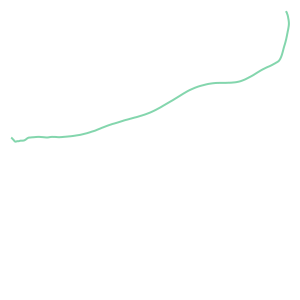

In [17]:
cl = centreline.geometry.iloc[0]
cl

In [18]:
#finding the intersection points perhaps 
#l is distance alnge the centreline unit
xs, ys = [], []


for idx, row in df.iterrows():
    L = row["L"]

    if pd.isna(L):
        xs.append(np.nan)
        ys.append(np.nan)
        continue

    pt = cl.interpolate(L)

    xs.append(pt.x)
    ys.append(pt.y)

df["x"] = xs
df["y"] = ys

df.head()


,Date,L,del_L,dt_days,dt_years,dL,dLdt_per_year,x,y
0,2015-01-03,1492.80,NaN,NaN,NaN,NaN,NaN,-182302.342764,-2.275255e+06
1,2015-01-15,1036.50,-456.270,12.0,0.032854,-456.30,-13888.631250,-182654.615903,-2.274965e+06
2,2015-01-27,1112.70,76.181,12.0,0.032854,76.20,2319.337500,-182594.683736,-2.275012e+06
3,2015-02-08,790.49,-322.240,12.0,0.032854,-322.21,-9807.266875,-182850.185458,-2.274816e+06
4,2015-02-20,1937.40,1146.900,12.0,0.032854,1146.91,34909.073125,-181981.364513,-2.275562e+06


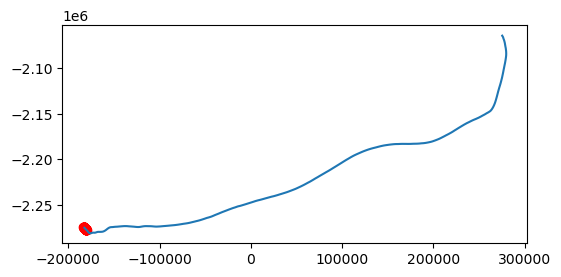

In [19]:
fig, ax = plt.subplots(figsize=(6,6))
centreline.plot(ax=ax)
ax.scatter(df["x"], df["y"],color="red")
plt.show()

#so this is right

In [20]:
vv = velocity["VelocityMap"].sel(band="vv")
vel_times = vv.time.values

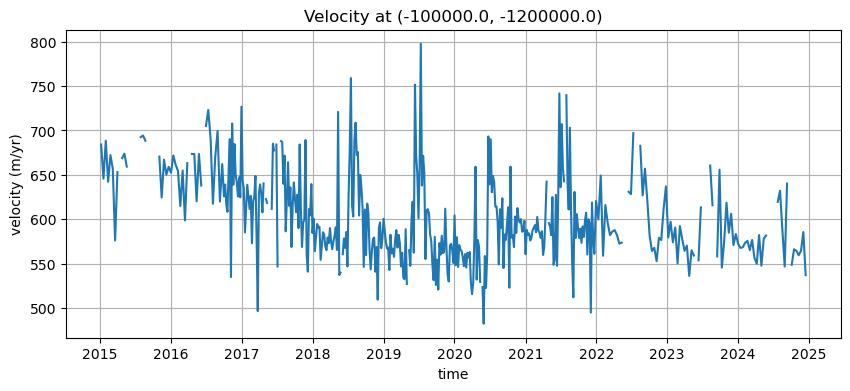

In [21]:

#random upstream point 
sample1 = vv.sel(x=-170000, y=-2200000, method="nearest")  # DataArray with time dim
df_sample = sample1.to_dataframe().reset_index()

plt.figure(figsize=(10,4))
plt.plot(df_sample["time"], df_sample["VelocityMap"])
plt.xlabel("time")
plt.ylabel("velocity (m/yr)")
plt.title(f"Velocity at ({x0}, {y0})")
plt.grid()
plt.show()



In [22]:
df

,Date,L,del_L,dt_days,dt_years,dL,dLdt_per_year,x,y
0,2015-01-03,1492.80,NaN,NaN,NaN,NaN,NaN,-182302.342764,-2.275255e+06
1,2015-01-15,1036.50,-456.270,12.0,0.032854,-456.30,-13888.631250,-182654.615903,-2.274965e+06
2,2015-01-27,1112.70,76.181,12.0,0.032854,76.20,2319.337500,-182594.683736,-2.275012e+06
3,2015-02-08,790.49,-322.240,12.0,0.032854,-322.21,-9807.266875,-182850.185458,-2.274816e+06
4,2015-02-20,1937.40,1146.900,12.0,0.032854,1146.91,34909.073125,-181981.364513,-2.275562e+06
...,...,...,...,...,...,...,...,...,...
241,2021-11-27,1394.10,-264.480,6.0,0.016427,-264.50,-16101.437500,-182377.541027,-2.275191e+06
242,2021-12-03,1204.90,-189.170,6.0,0.016427,-189.20,-11517.550000,-182522.167388,-2.275069e+06
243,2021-12-09,1446.70,241.830,6.0,0.016427,241.80,14719.575000,-182337.465762,-2.275225e+06
244,2021-12-15,1280.10,-166.670,6.0,0.016427,-166.60,-10141.775000,-182464.396164,-2.275117e+06


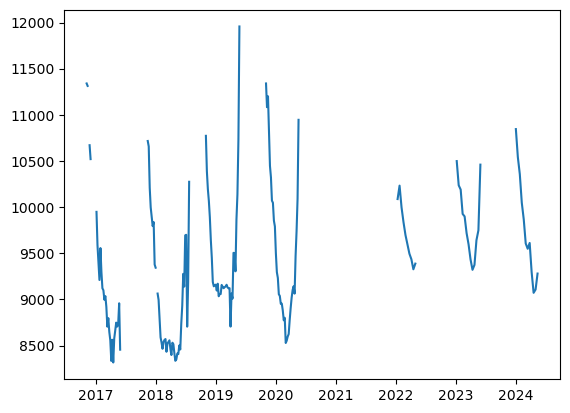

In [23]:
#at date = 1
x_pt = df.loc[0, "x"]
y_pt = df.loc[0, "y"]

vel_pt = vv.sel(x=x_pt, y=y_pt, method="nearest")
df_vel = vel_pt.to_dataframe().reset_index()
plt.plot(df_vel["time"], df_vel["VelocityMap"])

In [24]:
u_vals = []       # velocity at intersection (m/yr)

for _, row in df.iterrows():
    x = row["x"]
    y = row["y"]
    t = row["Date"]

    if pd.isna(x) or pd.isna(y) or pd.isna(t):
        u_vals.append(np.nan)
        continue

    v_intersect = vv.sel(time=t, x=x, y=y, method="nearest").values

    if np.isnan(v_intersect):
        u_vals.append(np.nan)
    else:
        u_vals.append(float(v_intersect))


df["u_per_yr"] = u_vals

In [29]:
df

,Date,L,del_L,dt_days,dt_years,dL,dLdt_per_year,x,y,u_per_yr
0,2015-01-03,1492.80,NaN,NaN,NaN,NaN,NaN,-182302.342764,-2.275255e+06,NaN
1,2015-01-15,1036.50,-456.270,12.0,0.032854,-456.30,-13888.631250,-182654.615903,-2.274965e+06,NaN
2,2015-01-27,1112.70,76.181,12.0,0.032854,76.20,2319.337500,-182594.683736,-2.275012e+06,NaN
3,2015-02-08,790.49,-322.240,12.0,0.032854,-322.21,-9807.266875,-182850.185458,-2.274816e+06,NaN
4,2015-02-20,1937.40,1146.900,12.0,0.032854,1146.91,34909.073125,-181981.364513,-2.275562e+06,NaN
...,...,...,...,...,...,...,...,...,...,...
241,2021-11-27,1394.10,-264.480,6.0,0.016427,-264.50,-16101.437500,-182377.541027,-2.275191e+06,NaN
242,2021-12-03,1204.90,-189.170,6.0,0.016427,-189.20,-11517.550000,-182522.167388,-2.275069e+06,NaN
243,2021-12-09,1446.70,241.830,6.0,0.016427,241.80,14719.575000,-182337.465762,-2.275225e+06,NaN
244,2021-12-15,1280.10,-166.670,6.0,0.016427,-166.60,-10141.775000,-182464.396164,-2.275117e+06,NaN


In [31]:
print("non-NaN velocities:", df["u_per_yr"].notna().sum(), "of", len(df))

non-NaN velocities: 26 of 246


In [ ]:
# assuming a veloicty of 1500 m/a to begin the calving series

u_constant = 1500.0 #unit is m /year 

df["u_per_year"] = u_constant


,Date,L,del_L,dt_days,dt_years,dL,dLdt_per_year,x,y,u_m_per_yr,calving_m_per_yr,u_per_year,calving,vel_date,vel_dt_days
0,2015-01-03,1492.80,NaN,NaN,NaN,NaN,NaN,-182302.342764,-2.275255e+06,NaN,NaN,1500.0,NaN,2015-01-06 12:00:00,3.5
1,2015-01-15,1036.50,-456.270,12.0,0.032854,-456.30,-13888.631250,-182654.615903,-2.274965e+06,NaN,NaN,1500.0,15388.631250,2015-01-18 12:00:00,3.5
2,2015-01-27,1112.70,76.181,12.0,0.032854,76.20,2319.337500,-182594.683736,-2.275012e+06,NaN,NaN,1500.0,-819.337500,2015-01-30 12:00:00,3.5
3,2015-02-08,790.49,-322.240,12.0,0.032854,-322.21,-9807.266875,-182850.185458,-2.274816e+06,NaN,NaN,1500.0,11307.266875,2015-02-11 12:00:00,3.5
4,2015-02-20,1937.40,1146.900,12.0,0.032854,1146.91,34909.073125,-181981.364513,-2.275562e+06,NaN,NaN,1500.0,-33409.073125,2015-02-23 12:00:00,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2021-11-27,1394.10,-264.480,6.0,0.016427,-264.50,-16101.437500,-182377.541027,-2.275191e+06,NaN,NaN,1500.0,17601.437500,2021-11-27 12:00:00,0.5
242,2021-12-03,1204.90,-189.170,6.0,0.016427,-189.20,-11517.550000,-182522.167388,-2.275069e+06,NaN,NaN,1500.0,13017.550000,2021-12-03 12:00:00,0.5
243,2021-12-09,1446.70,241.830,6.0,0.016427,241.80,14719.575000,-182337.465762,-2.275225e+06,NaN,NaN,1500.0,-13219.575000,2021-12-09 12:00:00,0.5
244,2021-12-15,1280.10,-166.670,6.0,0.016427,-166.60,-10141.775000,-182464.396164,-2.275117e+06,NaN,NaN,1500.0,11641.775000,2021-12-15 12:00:00,0.5


In [96]:
df["calving"] = df["u_per_year"] - df["dLdt_per_year"]

#calving unit is m /yr
# calving rate > 0 : terminus advance  (due to velocity)
# calving rate < 0 : terminus retreat (due to calving)

In [29]:
df

,Date,L,del_L,dt_days,dt_years,dL,dLdt_per_year,x,y,u_m_per_yr,calving_m_per_yr,u_per_year,calving
0,2015-01-03,1492.80,NaN,NaN,NaN,NaN,NaN,-182302.342764,-2.275255e+06,NaN,NaN,1500.0,NaN
1,2015-01-15,1036.50,-456.270,12.0,0.032854,-456.30,-13888.631250,-182654.615903,-2.274965e+06,NaN,NaN,1500.0,15388.631250
2,2015-01-27,1112.70,76.181,12.0,0.032854,76.20,2319.337500,-182594.683736,-2.275012e+06,NaN,NaN,1500.0,-819.337500
3,2015-02-08,790.49,-322.240,12.0,0.032854,-322.21,-9807.266875,-182850.185458,-2.274816e+06,NaN,NaN,1500.0,11307.266875
4,2015-02-20,1937.40,1146.900,12.0,0.032854,1146.91,34909.073125,-181981.364513,-2.275562e+06,NaN,NaN,1500.0,-33409.073125
...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2021-11-27,1394.10,-264.480,6.0,0.016427,-264.50,-16101.437500,-182377.541027,-2.275191e+06,NaN,NaN,1500.0,17601.437500
242,2021-12-03,1204.90,-189.170,6.0,0.016427,-189.20,-11517.550000,-182522.167388,-2.275069e+06,NaN,NaN,1500.0,13017.550000
243,2021-12-09,1446.70,241.830,6.0,0.016427,241.80,14719.575000,-182337.465762,-2.275225e+06,NaN,NaN,1500.0,-13219.575000
244,2021-12-15,1280.10,-166.670,6.0,0.016427,-166.60,-10141.775000,-182464.396164,-2.275117e+06,NaN,NaN,1500.0,11641.775000


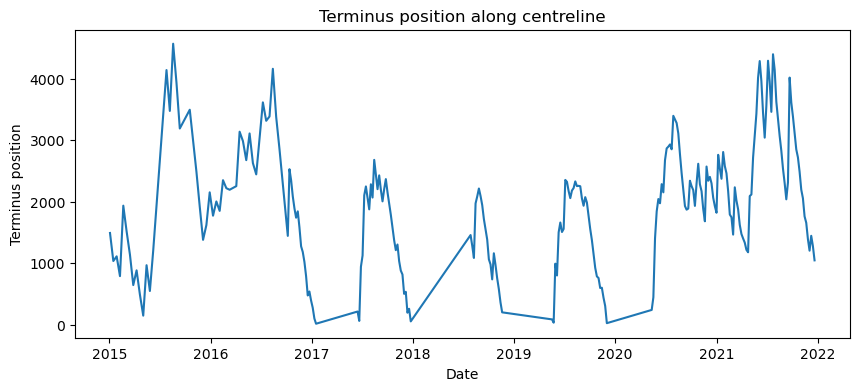

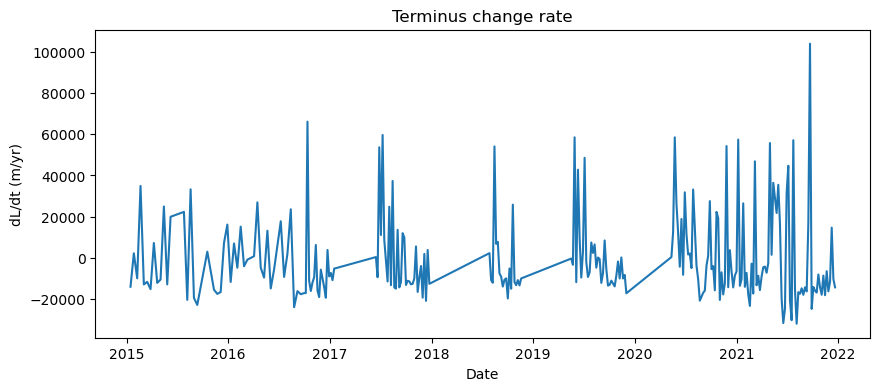

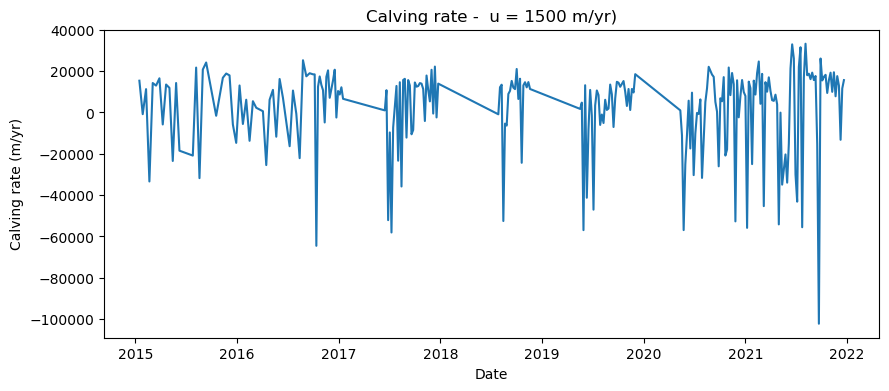

In [97]:

plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["L"])
plt.xlabel("Date")
plt.ylabel("Terminus position")
plt.title("Terminus position along centreline")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["dLdt_per_year"])
plt.xlabel("Date")
plt.ylabel("dL/dt (m/yr)")
plt.title("Terminus change rate")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["calving"])
plt.xlabel("Date")
plt.ylabel("Calving rate (m/yr)")
plt.title("Calving rate -  u = 1500 m/yr)")
plt.show()

In [34]:
# get bounds from centreline + termini points
minx = df["x"].min()
maxx = df["x"].max()
miny = df["y"].min()
maxy = df["y"].max()

buffer = 10000  # 10 km margin

bbox = {
    "minx": float(minx) - buffer,
    "maxx": float(maxx) + buffer,
    "miny": float(miny) - buffer,
    "maxy": float(maxy) + buffer,
}

print("new bbox:", bbox)


new bbox: {'minx': -193493.32992473277, 'maxx': -170184.61678305344, 'miny': -2287487.613616294, 'maxy': -2264385.090828327}
